# Evaluation of CCLM testruns with ERA5 for individual point data

In [14]:
import valenspy as vp
from valenspy.preprocessing_tasks.select import select_point

import warnings
import xarray as xr
import matplotlib.pyplot as plt


# Turn off all warnings
warnings.filterwarnings('ignore')

# define machine name - used for paths of (observational) datasets
machine = 'hortense'

model = "CCLM"

## 0 . Settings

In [15]:
# directory with experiments

experiments = ["EUR11_CO_TA_GC_TSO",
               "EUR11_CO_TT_GC_TSO", 
               "EUR11_CO_TT_EC_TSO", 
               "EUR11_NU_TE_GC_TSO", 
               "EUR11_NU_TT_GC_TSO", 
               "EUR11_NU_TT_EC_TSO", 
               "EUR11_NU_TT_EC_soil"
               ]

# do selection of individual points (do this in separate notebook.)
# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
    'channel'   : (-1.05, 50.14)
}
point_coord = d_point_coords['opwijk']


months_to_analyse = [5,6,7,8]



### plotting function

In [18]:
# ------------------------------
# 1. Load reference data


def plot_point_timeseries(variable: str, ref_dataset: str, experiments: list, point_coord: tuple, point_id:str,  months_to_analyse: list, ax=False): 
        
    # start up input manager
    manager = vp.InputManager(machine=machine)

    if ref_dataset=="ERA5": 
        region_to_load ="europe"
    elif ref_dataset=="ERA5-Land": 
        region_to_load = "belgium"

    # use input manager to load data, defined on settings above
    #ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq="daily",region=region, path_identifiers = ["-daily-"])
    if ref_dataset == 'ERA5' or ref_dataset== 'ERA5-Land':

        if variable == 'tasmax':        
            variable_to_load = "tas"
            ds_obs = manager.load_data(ref_dataset,variable_to_load, period=[1995,1995],freq="hourly",region=region_to_load)
            ds_obs = ds_obs.resample(time='1D').max().rename({'tas':variable})


        elif variable == "tasmin": 
            variable_to_load = "tas"
            ds_obs = manager.load_data(ref_dataset,variable_to_load, period=[1995,1995],freq="hourly",region=region_to_load)
            ds_obs = ds_obs.resample(time='1D').min().rename({'tas':variable}) 

    else: 
        ds_obs = manager.load_data(ref_dataset,variable, period=[1995,1995],freq=freq,region=region_to_load)
   
    # select point 
    ds_obs_point = select_point(ds_obs, point_coord)
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))


    # generate path of CCLM output

    # dictorionary to save data arrays of experiments
    d_da_mod_point = {}

    for experiment in experiments: 

        # define the CCLM files for the corresponding variable
        if variable == "tasmax": 
            daily_statistic = "max"

        elif variable == "tasmin": 
            daily_statistic = "min"

        else: 
            daily_statistic = "mean"
        
        # load data
        ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])


        # do selection
        ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

        da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        d_da_mod_point[experiment] = da_mod_point

    # do plotting
    # when no ax element is passed, create the figure within the function
    if not ax: 
        fig, ax = plt.subplots(figsize = (7,3))

    da_obs_point.plot(ax=ax, label = ref_dataset, color='k')

    for experiment in d_da_mod_point: 
        d_da_mod_point[experiment].plot(ax=ax, label = experiment, alpha=0.5)

    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
    ax.set_title(da_obs_point.attrs['long_name'], loc='left')

    # only add legend if stand-alone figure
    if not ax: 
        ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

        
    return ax



def plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=False):

    "Wrapper function to combine 4 point timeseries plot into one figure, with nice layout (legend and title)"
    fig, axes = plt.subplots(2,2,figsize = (16,6))
    axes = axes.flatten()

    for i,point_id in enumerate(d_point_coords): 
        ax = axes[i]
        ax = plot_point_timeseries(variable, ref_dataset, experiments, d_point_coords[point_id], point_id,  months_to_analyse, ax=ax)

        if i == 1: 
            ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout()


### 2m temperature

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/proje

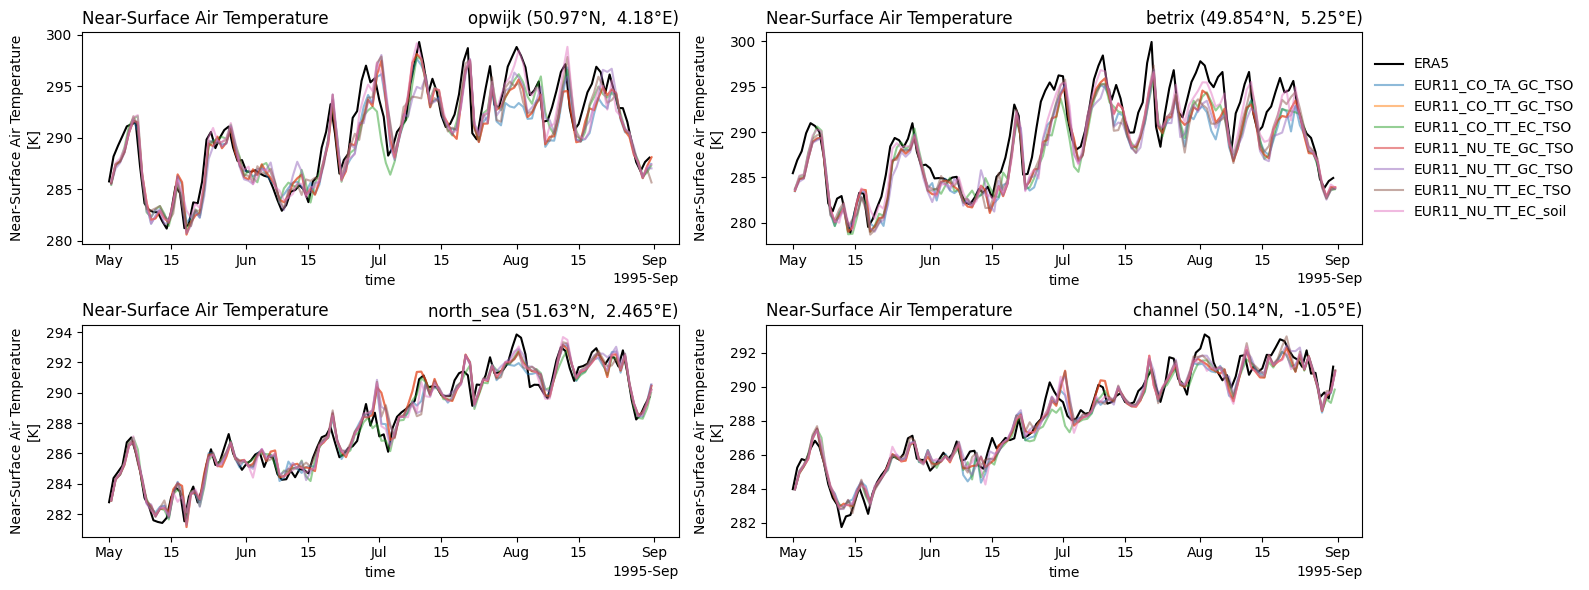

In [5]:
# variables of interest
variable = "tas"
region = 'europe'
ref_dataset = 'ERA5'
months_to_analyse = [5,6,7,8]

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymax.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']


KeyError: "No variable named 'tasmax'. Variables on the dataset include ['time', 'time_bnds', 'lon', 'lat', 'rlon', 'rlat', 'rotated_pole', 'height_2m', 'tas']"

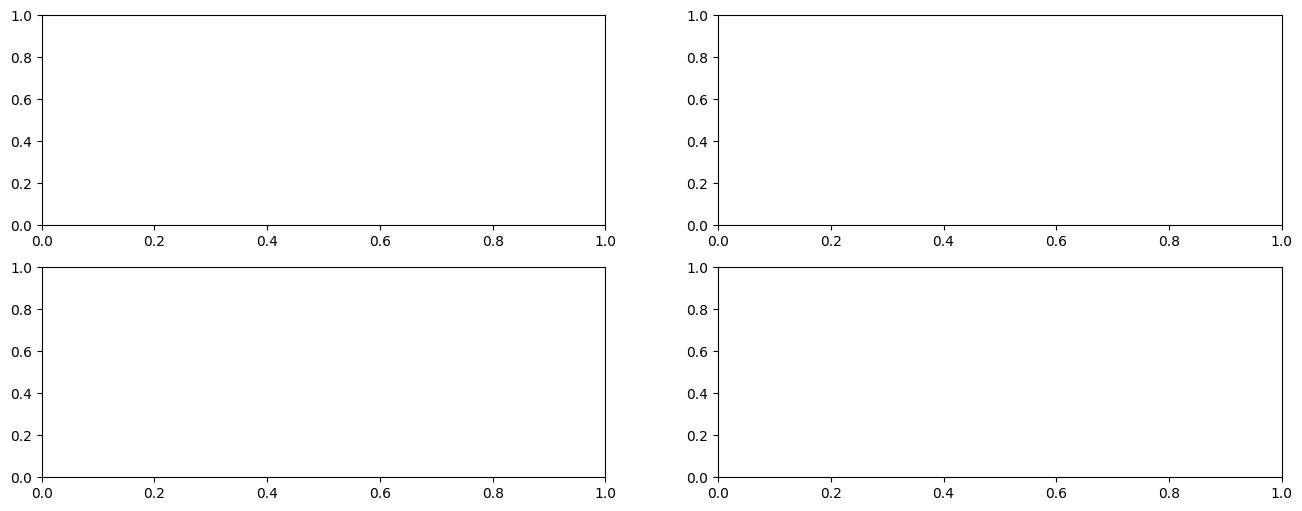

In [19]:
# variables of interest
variable = "tasmax"
region = 'europe'
ref_dataset = 'ERA5'
months_to_analyse = [5,6,7,8]

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

In [ ]:
# variables of interest
variable = "tasmin"
region = 'europe'
ref_dataset = 'ERA5'
months_to_analyse = [5,6,7,8]

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TA_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_CO_TT_GC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/proje

### Cloudiness

In [6]:
# variables of interest
variable = "clt"
region = 'belgium'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

NameError: name 'experiments' is not defined

### Total cloudiness in july

In [7]:
# variables of interest

variable = "clt"
region = 'belgium'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[7])

NameError: name 'experiments' is not defined

### Low clouds

In [8]:
# variables of interest

variable = "cll"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[8])

NameError: name 'experiments' is not defined

### medium level clouds

In [9]:
# variables of interest

variable = "clm"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[8])

NameError: name 'experiments' is not defined

### high level clouds

In [10]:
# variables of interest

variable = "clh"
region = 'europe'
ref_dataset = 'ERA5'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,[7])

NameError: name 'experiments' is not defined

### Sea level pressure

In [11]:
# variables of interest
variable = "psl"
region = 'belgium'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

NameError: name 'experiments' is not defined

### Precipitation -- units are not yet correct!!!


In [12]:
# variables of interest
variable = "pr"
region = 'europe'
ref_dataset = "ERA5"
unit_conversion = "pr"
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion)

NameError: name 'experiments' is not defined

### Latent heat flux

In [13]:
# variables of interest
variable = "hfls"
region = 'belgium'
ref_dataset = 'ERA5-Land'
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=True)

NameError: name 'experiments' is not defined

### Sensible heat flux

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT ValEnsPy CF compliant: ['hfss']
The following attributes are missing or incorrect for the variable hfss:
Attribute       Actual                    Expected                 
-----------------------------------------------------------------
units           J m**-2                   W m-2                    
did unit conversion
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/surface_sensible_heat_flux/era5-land-hourly-belgium-surface_sensible_heat_flux-1995.nc
Variable attributes are missing or incorrect
The file is NOT ValEnsPy CF compliant.
0.00% of the variables are ValEnsPy CF compliant
NOT

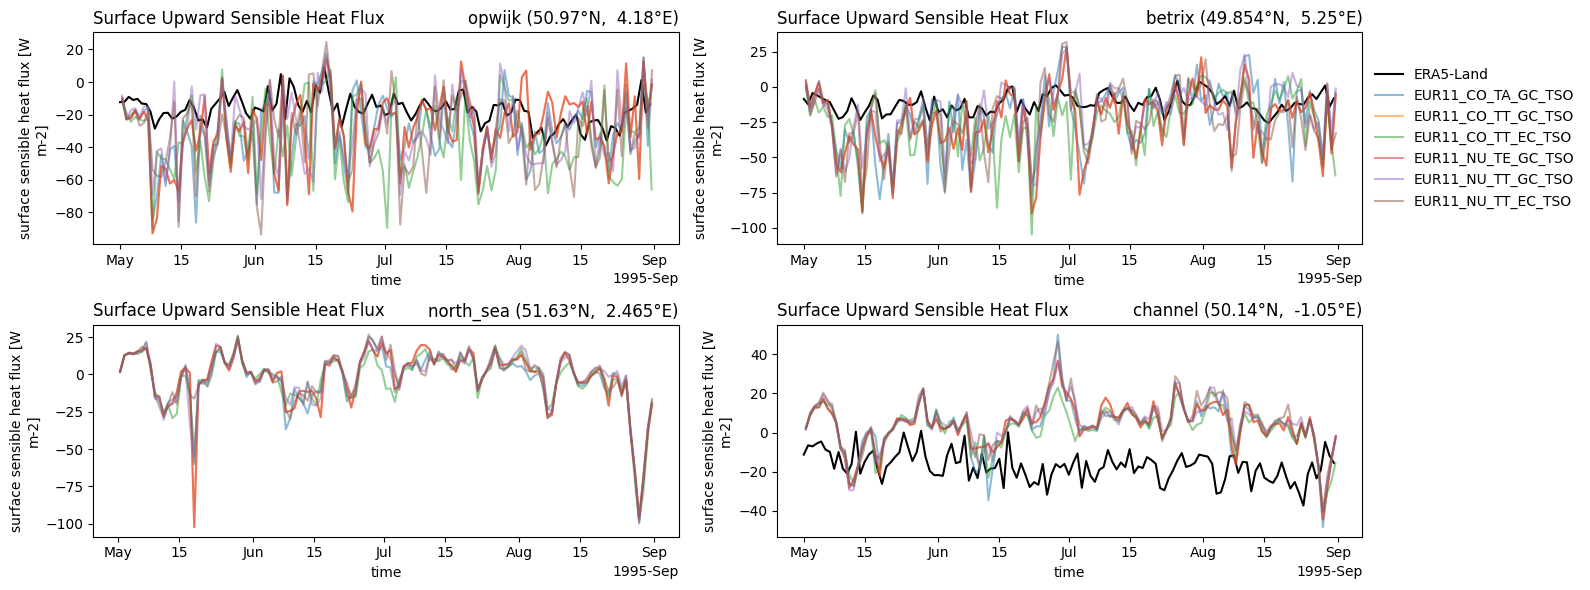

In [ ]:
# variables of interest
variable = "hfss"
region = 'belgium'
ref_dataset = 'ERA5-Land'
plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse, unit_conversion=True)

### Surface temperature

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly/skin_temperature/era5-land-hourly-belgium-skin_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['ts']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5-land/belgium/hourly

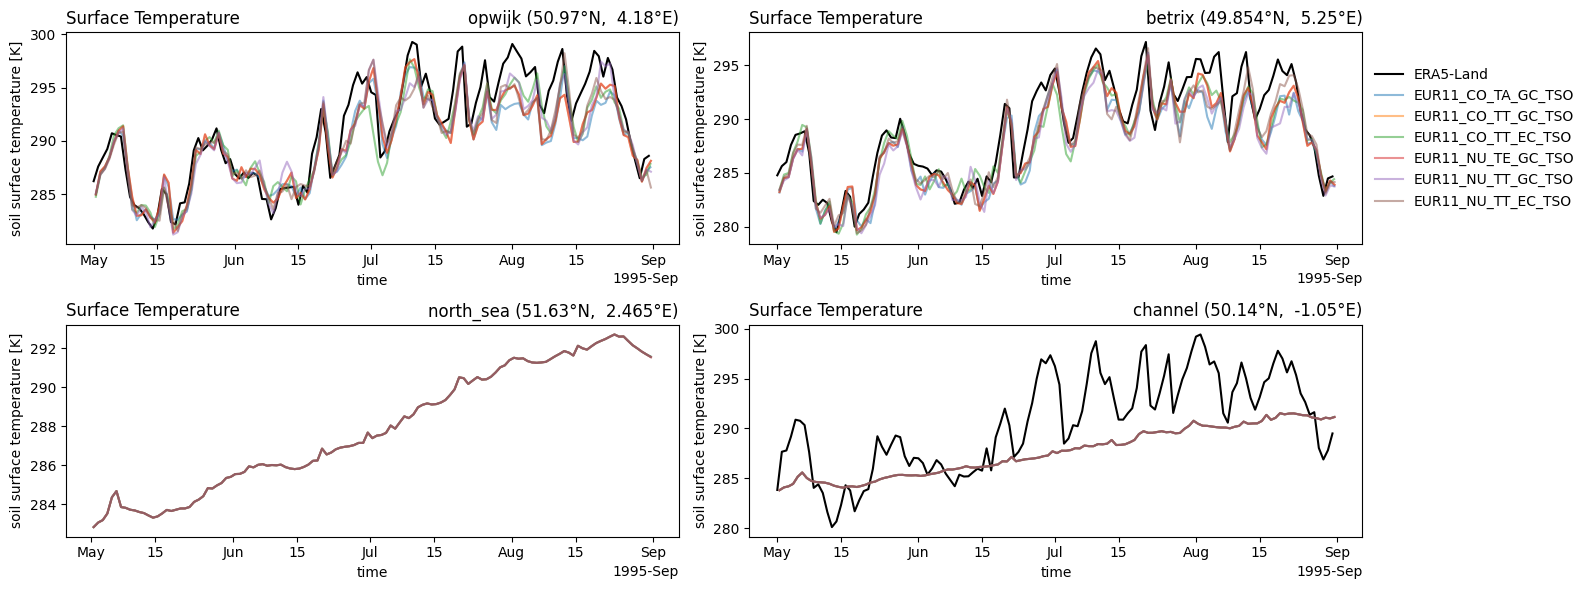

In [ ]:
# variables of interest
variable = "ts"
region = 'belgium'
ref_dataset = 'ERA5-Land'

plot_timeseries_fourpoints(variable, ref_dataset, experiments, d_point_coords,  months_to_analyse)

## Points location on a map

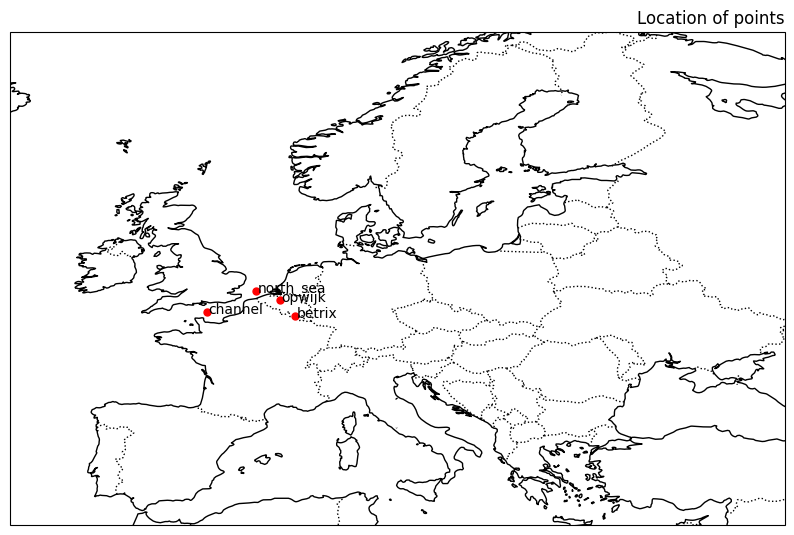

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

region = 'europe'

def plot_points_map(d_coord_points: dict, region: str, bounds: str): 

    # Create a figure and set the projection to PlateCarree
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot each point and add a label
    for key, (lon, lat) in d_coord_points.items():
        ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
        ax.text(lon + 0.1, lat - 0.1, key, transform=ccrs.PlateCarree())

    # Set extent if needed (optional)
    lat_bounds = bounds[region]['lat_bounds']
    lon_bounds = bounds[region]['lon_bounds']
    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    ax.set_title('Location of points', loc='right')
    # Show the plot
    plt.show()
    fig.savefig("./plots/points_map.png")


plot_points_map(d_coord_points, region, bounds)